Running...
Completed Iterations:  0
Completed Iterations:  100
Completed Iterations:  200
Completed Iterations:  300
Completed Iterations:  400
Completed Iterations:  500
Completed Iterations:  600
Completed Iterations:  700
Completed Iterations:  800
Completed Iterations:  900
Completed Iterations:  1000
Completed Iterations:  1100
Completed Iterations:  1200
Completed Iterations:  1300
Completed Iterations:  1400
Completed Iterations:  1500
Completed Iterations:  1600
Completed Iterations:  1700
Completed Iterations:  1800
Completed Iterations:  1900
Execution time: 46.19028854370117 seconds


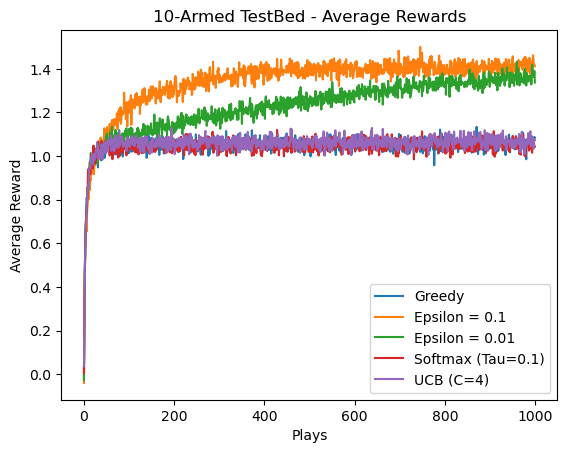

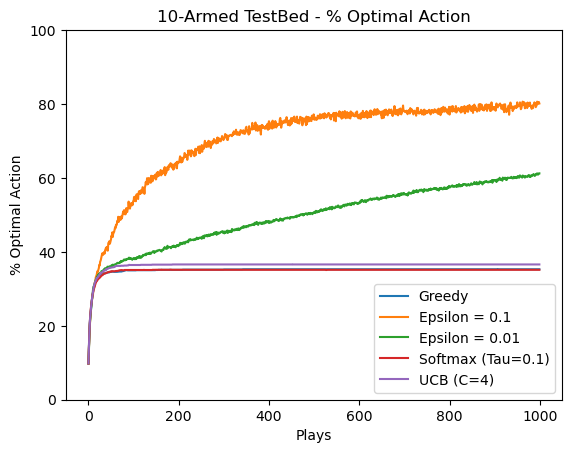

In [15]:
import numpy as np
import matplotlib.pyplot as plt
import time

################################################################
# TestBed class containing the states and actions, and the overall rules of the test
class Testbed(object):

    def __init__(self, nArms, mean, stDev):

        # Number of arms
        self.nArms = nArms

        # Used for the Gaussian random actions
        self.mean = mean        # Mean
        self.stDev = stDev      # Standard Deviation

        self.actArr = np.zeros(nArms)   # Array to store action values
        self.optim = 0                  # Store optimal value for greedy
        self.reset()

    # Reset testbed for next iteration
    def reset(self):
        # Set random gaussian/normal values using numpy function, requires mean, standard deviation and number of arms
        self.actArr = np.random.normal(self.mean, self.stDev, self.nArms)

        # Identify the maximum value in action array
        self.optim = np.argmax(self.actArr)


################################################################
# Agent Class - Controls the agents movement and behaviour in the environment interacting with the testbed
# and receives information on the current position
class Agent(object):

    # Constructor
    def __init__(self,nArms, eProb=0, tau=0, c=0):
        self.nArms = nArms      # Number of arms
        self.eProb = eProb      # Epsilon probability
        self.tau = tau          # Tau value for softmax
        self.c = c              # Exploration parameter for UCB

        self.timeStep = 0                    # Time Step t
        self.lastAction = None               # Store last action

        self.kAction = np.zeros(nArms)          # count of actions taken at time t
        self.rSum = np.zeros(nArms)             # Sums number of rewards
        self.valEstimates = np.zeros(nArms)     # action value estimates sum(rewards)/Amount


    # Return string for graph legend
    def __str__(self):
        if self.tau > 0:
            return "Softmax (Tau={})".format(self.tau)
        elif self.c > 0:
            return "UCB (C={})".format(self.c)
        elif self.eProb!=0:
            return "Epsilon = " + str(self.eProb)
        else:
            return "Greedy"
#         elif self.tau > 0:
#             return "Softmax (Tau={})".format(self.tau)
#         elif self.c > 0:
#             return "UCB (C={})".format(self.c)
#         else:
#             return "Epsilon = " + str(self.eProb)


    # Selects action based on a epsilon-greedy behaviour,
    # if epsilon equals zero, then the agent performs a greedy selection


    
    def action(self):
    ### POLICY ###
        # Epsilon-greedy method
        if self.eProb > 0:
            randProb = np.random.random()   # Pick random probability between 0-1
            if randProb < self.eProb:
                a = np.random.choice(len(self.valEstimates))    # Select random action
            else:
                a = np.argmax(self.valEstimates)     # Greedy action selection
        # Greedy method
        elif self.eProb == 0:
            a = np.argmax(self.valEstimates)
        # Softmax method
        elif self.tau > 0:
            softmax_prob = np.exp(self.valEstimates / self.tau) / np.sum(np.exp(self.valEstimates / self.tau))
            a = np.random.choice(range(self.nArms), p=softmax_prob)
        # UCB method
        elif self.c > 0:
            exploration = np.sqrt(np.log(self.timeStep + 1) / (self.kAction + 1e-5))
            ucb_values = self.valEstimates + self.c * exploration
            a = np.argmax(ucb_values)
        else:
            raise ValueError("Invalid algorithm parameters: either eProb, tau, or c should be greater than 0.")

        # save last action in variable, and return result
        self.lastAction = a
        return a




    # Interpreter - updates the value extimates amounts based on the last action
    def interpreter(self, reward):
        # Add 1 to the number of action taken in step
        At = self.lastAction

        self.kAction[At] += 1       # Add 1 to action selection
        self.rSum[At] += reward     # Add reward to sum array

        # Calculate new action-value, sum(r)/ka
        self.valEstimates[At] = self.rSum[At]/self.kAction[At]

        # Increase time step
        self.timeStep += 1


    # Reset all variables for next iteration
    def reset(self):
        self.timeStep = 0                    # Time Step t
        self.lastAction = None               # Store last action

        self.kAction[:] = 0                  # count of actions taken at time t
        self.rSum[:] = 0
        self.valEstimates[:] = 0   # action value estimates Qt ~= Q*(a)


################################################################
# Environment class to control all objects (agent/Testbed)
class Environment(object):

    # Constructor
    def __init__(self, testbed, agents, plays, iterations):
        self.testbed = testbed
        self.agents = agents

        self.plays = plays
        self.iterations = iterations


    # Run Test
    def play(self):

        # Array to store the scores, number of plays X number of agents
        scoreArr = np.zeros((self.plays, len(self.agents)))
        # Array to maintain optimal count, Graph 2
        optimlArr = np.zeros((self.plays, len(self.agents)))

        # loop for number of iterations
        for iIter in range(self.iterations):

            # Print statement after every 100 iterations
            if (iIter%100) == 0:
                print("Completed Iterations: ",iIter)

            #Reset testbed and all agents
            self.testbed.reset()
            for agent in self.agents:
                agent.reset()


            # Loop for number of plays
            for jPlays in range(self.plays):
                agtCnt = 0

                for kAgent in self.agents:
                    actionT =  kAgent.action()

                    # Reward - normal dist (Q*(at), variance = 1)
                    rewardT = np.random.normal(self.testbed.actArr[actionT], scale=1)

                    # Agent checks state
                    kAgent.interpreter(reward=rewardT)

                    # Add score in arrary, graph 1
                    scoreArr[jPlays,agtCnt] += rewardT

                    # check the optimal action, add optimal to array, graph 2
                    if actionT == self.testbed.optim:
                        optimlArr[jPlays,agtCnt] += 1

                    agtCnt += 1

        #return averages
        scoreAvg = scoreArr/self.iterations
        optimlAvg = optimlArr/self.iterations

        return scoreAvg, optimlAvg


################################################################
## MAIN ##
if __name__ == "__main__":
    start_time = time.time()    #store time to monitor execution
    nArms = 10                  # n number of bandits
    iterations = 2000         # number of repeated iterations
    plays = 1000                # number of pplays per iteration

    # Setup objects to contain infomration about the agents, testbed, and environment
    testbed = Testbed(nArms=nArms,mean=0,stDev=1)
    agents = [
        Agent(nArms=nArms),
        Agent(nArms=nArms,eProb=0.1),
        Agent(nArms=nArms,eProb=0.01),
        Agent(nArms=nArms, tau=0.1),  # Softmax with tau=0.1
        Agent(nArms=nArms, c=4)        # UCB with c=2
    ]
    environment = Environment(testbed=testbed,agents=agents,plays=plays,iterations=iterations)

    # Run Environment
    print("Running...")
    g1Scores, g2Optimal = environment.play()
    print("Execution time: %s seconds" % (time.time() - start_time))


    #Graph 1 - Averate rewards over all plays
    plt.title("10-Armed TestBed - Average Rewards")
    plt.plot(g1Scores)
    plt.ylabel('Average Reward')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.show()

    #Graph 1 - optimal selections over all plays
    plt.title("10-Armed TestBed - % Optimal Action")
    plt.plot(g2Optimal * 100)
    plt.ylim(0, 100)
    plt.ylabel('% Optimal Action')
    plt.xlabel('Plays')
    plt.legend(agents, loc=4)
    plt.show()
